In [21]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

import acoustotreams

k0s = 2 * np.pi * np.linspace(50000, 500000, 200) / 343
materials = [acoustotreams.AcousticMaterial(1050 + 100j, 2350 - 300j), 
             acoustotreams.AcousticMaterial(998, 1497)]
kzs = [0]
mmax = 10
radius = 0.005
cylinders = [acoustotreams.AcousticTMatrixC.cylinder(kzs, mmax, k0, radius, materials) for k0 in k0s]

In [22]:
xw_sca = np.array([tm.xw_sca_avg for tm in cylinders]) / (2 * radius)
xw_ext = np.array([tm.xw_ext_avg for tm in cylinders]) / (2 * radius)

In [23]:
cwb_mmax0 = acoustotreams.ScalarCylindricalWaveBasis.default(kzs, 1)
cylinders_mmax0 = [tm[cwb_mmax0] for tm in cylinders]
xw_sca_mmax0 = np.array([tm.xw_sca_avg for tm in cylinders_mmax0]) / (2 * radius)
xw_ext_mmax0 = np.array([tm.xw_ext_avg for tm in cylinders_mmax0]) / (2 * radius)

/tmp/ipykernel_22464/2198964618.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


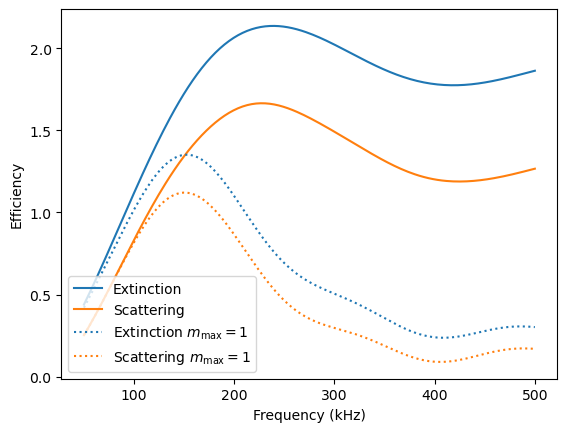

In [24]:
fig, ax = plt.subplots()
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xw_ext)
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xw_sca)
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xw_ext_mmax0, color="C0", linestyle=":")
ax.plot(k0s * 343 / (2 * np.pi) / 1000, xw_sca_mmax0, color="C1", linestyle=":")
ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Efficiency")
ax.legend(["Extinction", "Scattering", "Extinction $m_{\\rm max}=1$", "Scattering $m_{\\rm max}=1$"])
fig.show()

In [27]:
tm = cylinders[50]
inc = acoustotreams.plane_wave_scalar([tm.k0, 0, 0], k0=tm.k0, material=tm.material)
sca = tm.sca(inc)

In [28]:
x = np.linspace(-0.0075, 0.0075, 101)
y = np.linspace(-0.0075, 0.0075, 101)
def compute_intensity(i, j):
    r = [x[j], y[i], 0]
    result = 0  
    if tm.valid_points(r, [radius]): 
        result = np.abs(inc.pfield(r) + sca.pfield(r))**2  
    else:
        result = np.nan
    return i, j, result  
results = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j) for i in range(len(y)) for j in range(len(x))
)
intensity = np.zeros((len(y), len(x)))
for i, j, result in results:
    intensity[i, j] = result

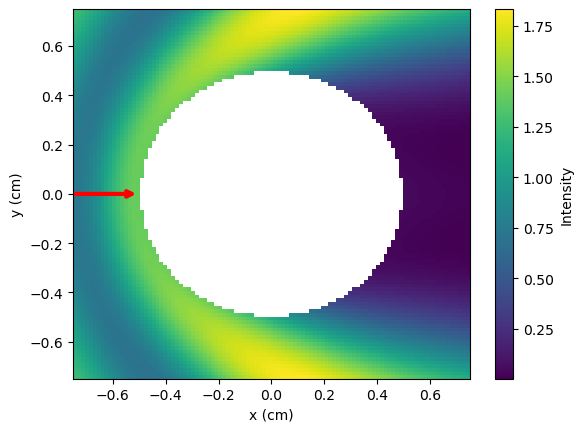

In [29]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity,
    extent = [x.min() * 100, x.max() * 100, y.min() * 100, y.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.annotate(
    "", 
    xy=(-0.5, 0),
    xytext=(-0.75, 0), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()

In [32]:
phi = np.linspace(0, 2 * np.pi, 301)
radpattern = np.zeros(len(phi))
def compute_radpattern(i):
    n = [np.cos(phi[i]), np.sin(phi[i]), 0]
    return 0.5 * np.real(sca.pamplitudeff(n) * np.conjugate(sca.vamplitudeff(n)[0]))
radpattern = Parallel(n_jobs=-1)(
    delayed(compute_radpattern)(i) for i in range(len(phi))
)

/tmp/ipykernel_22464/3079650900.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


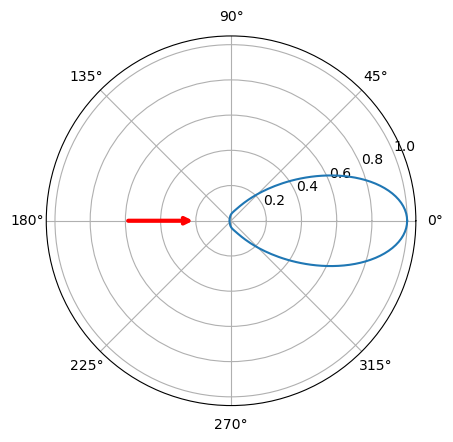

In [36]:
ax = plt.figure()
ax = plt.subplot(111, polar=True) 
ax.plot(phi, radpattern / np.max(radpattern) )
ax.annotate(
    "", 
    xy=(np.pi, 0.2), 
    xytext=(np.pi, 0.6),
    arrowprops=dict(
        arrowstyle="->", 
        color="red", 
        lw=3
    )
)
fig.show()